<a href="https://colab.research.google.com/github/pratyushsetu28/multinomial-sentiment/blob/main/Multinomial_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
training CNN model for image and emoji
"""

import math
import numpy as np
import pandas as pd

get_ipython().system("pip install scikit-plot")
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

df = pd.read_csv('/content/drive/MyDrive/dataset_project/fer2013.csv')

emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}


img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))



X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

def build_net(optim):

    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]


train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

batch_size = 32
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]


model = build_net(optims[1])
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

fer_json = model.to_json()
with open("/content/drive/MyDrive/dataset_project/fer1.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("/content/drive/MyDrive/dataset_project/fer1.h5")

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1009/1009 [==============================] - 2588s 3s/step - loss: 2.3520 - accuracy: 0.2078 - val_loss: 1.6344 - val_accuracy: 0.3477
Epoch 2/100
1009/1009 [==============================] - 2613s 3s/step - loss: 1.6832 - accuracy: 0.3337 - val_loss: 1.6235 - val_accuracy: 0.4007
Epoch 3/100
1009/1009 [==============================] - 2579s 3s/step - loss: 1.5005 - accuracy: 0.4198 - val_loss: 1.3335 - val_accuracy: 0.4851
Epoch 4/100
 246/1009 [======>.......................] - ETA: 31:36 - loss: 1.3961 - accuracy: 0.4720

In [ ]:
"""training CNN model for text
"""
import pandas as pd
import numpy as np
import nltk

from tensorflow.keras.utils import plot_model

nltk.download('punkt')

from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

num_classes = 5
embed_num_dims = 300
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

data_train = pd.read_csv('/content/drive/MyDrive/dataset_project/text/data_test.csv', encoding='utf-8')
data_test = pd.read_csv('/content/drive/MyDrive/dataset_project/text/data_train.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

def clean_text(data):

    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)


    data = word_tokenize(data)

    return data
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index


vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}


y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

    os.remove('wiki-news-300d-1M.vec.zip')

embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)

# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

batch_size = 256
epochs = 6

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

text_json = model.to_json()
with open("text.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("/content/drive/MyDrive/dataset_project/text/text_model.h5")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Number of unique words: 12088


KeyboardInterrupt: ignored

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


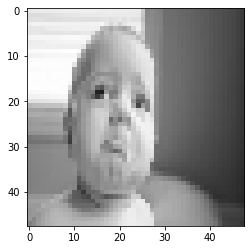

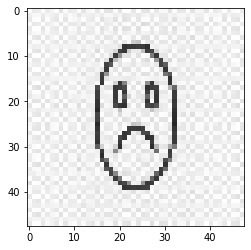

The situation is getting worse day by day
classification label : sadness


In [ ]:
"""
application where we provide image , text and emoji as input to get
predicted classification
"""

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib import pyplot
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
import time

import pandas as pd
import numpy as np
import nltk

from tensorflow.keras.utils import plot_model

nltk.download('punkt')
# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.models import model_from_json

from PIL import Image
from numpy import asarray
import numpy as np
import cv2



# text preprocessing


def clean_text(data):

    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)
    return data

def message_preprocess(msg):

     message = []
     message.append(msg)
     num_classes = 5
     embed_num_dims = 300
     max_seq_len = 500


     data_test = pd.read_csv('/content/drive/MyDrive/dataset_project/text/data_test.csv', encoding='utf-8')
     data_train = pd.read_csv('/content/drive/MyDrive/dataset_project/text/data_train.csv', encoding='utf-8')
     data = data_train.append(data_test, ignore_index=True)

     texts = [' '.join(clean_text(text)) for text in data.Text]
     tokenizer = Tokenizer()
     tokenizer.fit_on_texts(texts)
     seq = tokenizer.texts_to_sequences(message)
     padded = pad_sequences(seq, maxlen=max_seq_len)
     return padded


def pred_vec_msg(msg):
     message = message_preprocess(msg)
     model_t = tf.keras.models.load_model('/content/drive/MyDrive/dataset_project/text/text_model.h5')

     pred_t = model_t.predict(message)[0]

     pred = []
     pred.append(pred_t[2])
     pred.append(0)
     pred.append(pred_t[1])
     pred.append(pred_t[0])
     pred.append(pred_t[3])
     pred.append(0)
     pred.append(pred_t[4])
     pred_t = np.array(pred)
     return pred_t / (np.linalg.norm(pred_t))


##

def image_preprocess(path_to_image):

    img = cv2.imread(path_to_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # ADD THIS
    img = cv2.resize(gray, (48,48))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    data_i = np.array(img)
    data_i.resize(1,48,48,1)
    return data_i

def pred_vec_img(path_to_image):
    data_i = image_preprocess(path_to_image)
    json_file = open('/content/drive/MyDrive/dataset_project/fer.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("/content/drive/MyDrive/dataset_project/fer.h5")

    model_i = loaded_model
    pred_i = model_i.predict(data_i)
    return pred_i[0] / (np.linalg.norm(pred_i[0]))
# report the size of the thumbnail

def combine_vectors(vec_img , vec_text ,vec_emoji ) :
    return (vec_img + vec_text + vec_emoji)/3



# input
img = '/content/drive/MyDrive/dataset_project/images.jpeg'

text = 'The situation is getting worse day by day'

emoji = '/content/drive/MyDrive/dataset_project/images (1).jpeg'

pred_t = pred_vec_msg(text)
pred_i = pred_vec_img(img)
pred_e = pred_vec_img(emoji)


pred = combine_vectors(pred_i , pred_t , pred_e)
pred[1] = (pred[1]*3)/2
pred[5] = (pred[5]*3)/2
emotion_label_to_text = {0:'anger',
                         1:'disgust',
                         2:'fear',
                         3:'happiness',
                         4: 'sadness',
                         5: 'surprise',
                         6: 'neutral'}



print(text)

print("classification label : ",end="")

print( emotion_label_to_text[np.argmax(pred)])

# summarize shape


